In [ ]:
!git clone https://github.com/breakthe-rule/GenSolve.git
%cd GenSolve
!unzip -q GenSolve_TC.zip -d /content
%cd ..

Cloning into 'GenSolve'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), 335.31 KiB | 9.06 MiB/s, done.
/GenSolve
replace /content/GenSolve_TC/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **EDA**

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data into a DataFrame
df = pd.read_csv("/content/GenSolve_TC/occlusion2.csv", header=None, names=['Curve', 'Shape', 'X', 'Y'])

# 1. Basic Dataset Information
print("Basic Information:")
print(df.info())

# 2. Check for Missing Values
print("\nMissing Values:")
print(df.isnull().sum())

# 3. Summary Statistics
print("\nSummary Statistics:")
print(df.describe())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Curve   1636 non-null   float64
 1   Shape   1636 non-null   float64
 2   X       1636 non-null   float64
 3   Y       1636 non-null   float64
dtypes: float64(4)
memory usage: 51.2 KB
None

Missing Values:
Curve    0
Shape    0
X        0
Y        0
dtype: int64

Summary Statistics:
             Curve   Shape            X            Y
count  1636.000000  1636.0  1636.000000  1636.000000
mean      2.911369     0.0   123.553578    94.471729
std       1.080873     0.0    69.313477    42.902791
min       0.000000     0.0     0.501571     0.500000
25%       2.000000     0.0    59.871796    61.597363
50%       3.000000     0.0   127.441826   105.487274
75%       4.000000     0.0   189.893616   125.549728
max       4.000000     0.0   241.964462   165.350006


In [54]:
# Group by Curve and Shape, then calculate the number of unique shapes
unique_shapes_df = df.groupby(['Curve', 'Shape']).size().reset_index(name='Count of coordinates')
print("Number of Unique Shapes after GroupBy:")
print(unique_shapes_df)

# Calculate Min and Max X, Y Coordinates for Each Shape
shape_bounds_df = df.groupby(['Curve', 'Shape']).agg(
    X_Min=('X', 'min'),
    X_Max=('X', 'max'),
    Y_Min=('Y', 'min'),
    Y_Max=('Y', 'max')
).reset_index()

print("\nMin and Max X, Y Coordinates for Each Shape:")
print(shape_bounds_df)

Number of Unique Shapes after GroupBy:
   Curve  Shape  Count of coordinates
0    0.0    0.0                    58
1    1.0    0.0                    67
2    2.0    0.0                   485
3    3.0    0.0                   378
4    4.0    0.0                   648

Min and Max X, Y Coordinates for Each Shape:
   Curve  Shape       X_Min       X_Max       Y_Min       Y_Max
0    0.0    0.0   22.847235   40.832001  105.980003  126.129997
1    1.0    0.0  196.641998  215.881302   46.180000   68.770000
2    2.0    0.0   27.601999  204.662003    0.500000  126.133141
3    3.0    0.0   52.181999  205.921997   85.760002  165.350006
4    4.0    0.0    0.501571  241.964462   36.674747  141.322678


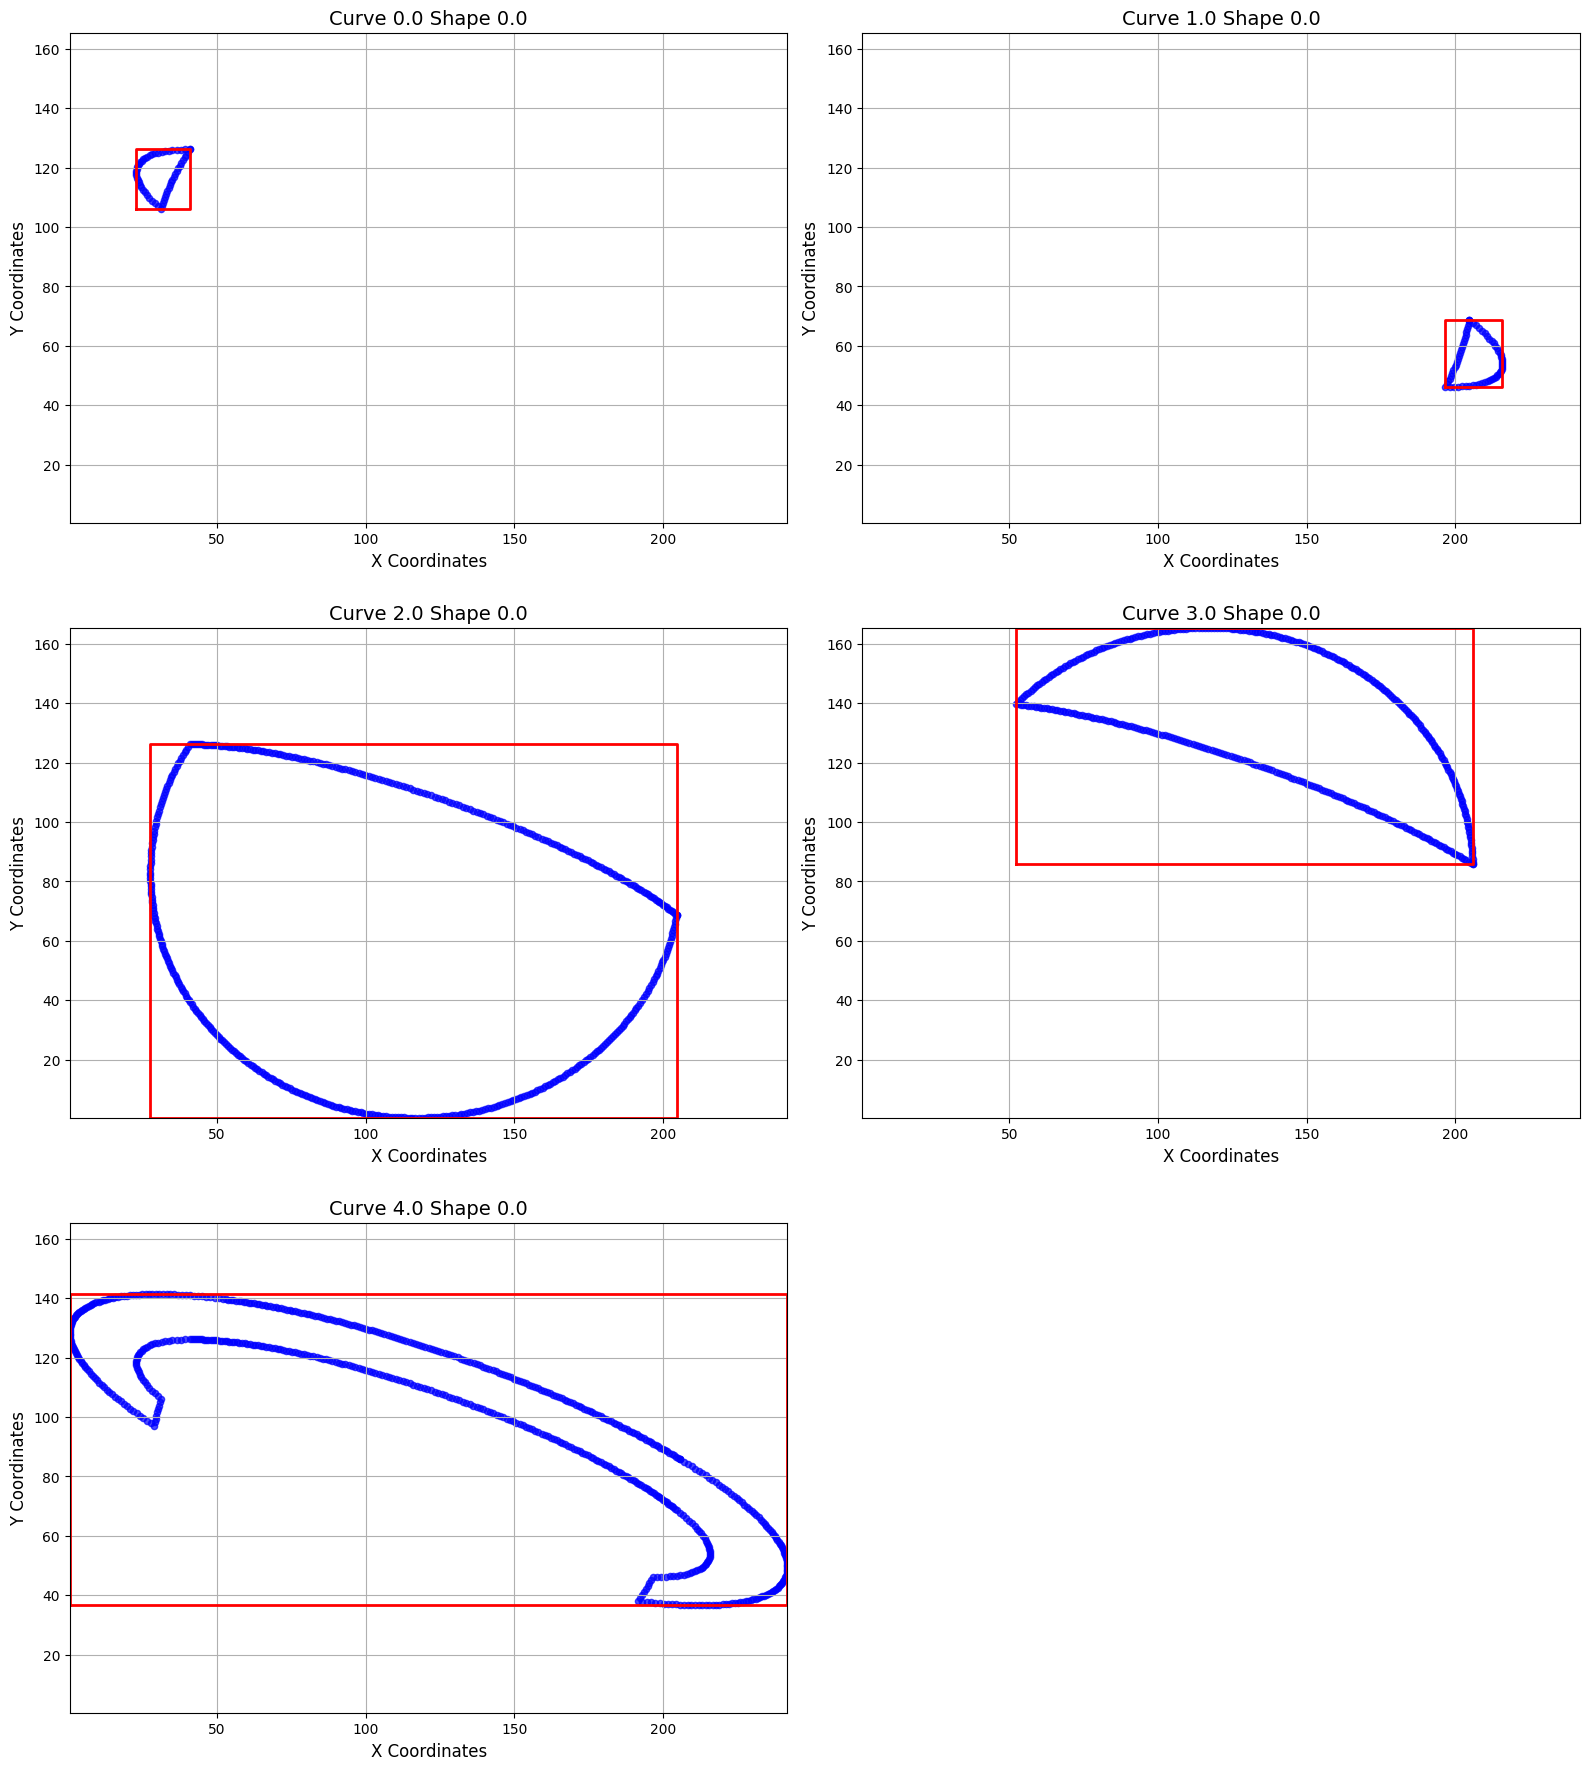

In [48]:
shape_bounds_df = df.groupby(['Curve', 'Shape']).agg(
    X_Min=('X', 'min'),
    X_Max=('X', 'max'),
    Y_Min=('Y', 'min'),
    Y_Max=('Y', 'max')
).reset_index()

# Merge the original dataframe with the bounds data
df_with_bounds = pd.merge(df, shape_bounds_df, on=['Curve', 'Shape'])

# Determine the number of subplots needed
num_shapes = df_with_bounds.groupby(['Curve', 'Shape']).ngroups
cols = 2  # Reduce columns to make the plots larger
rows = int(np.ceil(num_shapes / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 6))
axes = axes.flatten()

# Set the same limits for all subplots
x_min_global = df['X'].min()
x_max_global = df['X'].max()
y_min_global = df['Y'].min()
y_max_global = df['Y'].max()

# Plot each shape with its bounding box
for idx, ((curve, shape), group) in enumerate(df_with_bounds.groupby(['Curve', 'Shape'])):
    ax = axes[idx]

    # Plot the individual points of the shape
    ax.scatter(group['X'], group['Y'], alpha=0.7, s=20, c='blue')

    # Plot the bounding box
    x_min, x_max = group['X_Min'].values[0], group['X_Max'].values[0]
    y_min, y_max = group['Y_Min'].values[0], group['Y_Max'].values[0]
    ax.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color='red', linewidth=2)

    # Labels and Titles
    ax.set_title(f'Curve {curve} Shape {shape}', fontsize=14)
    ax.set_xlabel('X Coordinates', fontsize=12)
    ax.set_ylabel('Y Coordinates', fontsize=12)

    # Ensure the aspect ratio is correct and apply the same limits
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(x_min_global, x_max_global)
    ax.set_ylim(y_min_global, y_max_global)
    ax.grid(True)

# Remove any empty subplots
for i in range(num_shapes, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# **Regularizing, Finding Symmetry and Curve Completion**

In below cells we have solved the problem of regularizing shape finding symmetry and curve completion in single piece of code.

In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import cv2
from scipy.interpolate import UnivariateSpline, interp1d
import matplotlib.pyplot as plt

##***Helper Functions***

In [20]:
# Smoothing function
def smooth_points(x, y, s=0):
    """
    Smooths the provided x and y points using a univariate spline with linear interpolation.

    Parameters:
        x (array-like): The x-coordinates of the points.
        y (array-like): The y-coordinates of the points.
        s (float): Smoothing factor. Default is 0, which means the spline will interpolate through the points.

    Returns:
        tuple: Two arrays, representing the smoothed x and y points.
    """
    # Create a univariate spline for the x points with linear interpolation (k=1)
    spline_x = UnivariateSpline(range(len(x)), x, s=s, k=1)
    # Create a univariate spline for the y points with linear interpolation (k=1)
    spline_y = UnivariateSpline(range(len(y)), y, s=s, k=1)

    # Evaluate the spline across the original range to obtain the smoothed points
    return spline_x(range(len(x))), spline_y(range(len(y)))


# Interpolation function
def interpolate_points(x, y, num_points):
    """
    Interpolates the given x and y points to generate a specified number of points along the curve.

    Parameters:
        x (array-like): The x-coordinates of the points.
        y (array-like): The y-coordinates of the points.
        num_points (int): The number of interpolated points to generate.

    Returns:
        tuple: Two arrays, representing the interpolated x and y points.
    """
    # Create a normalized parameter t based on the length of the original data
    t = np.linspace(0, 1, len(x))

    # Create linear interpolation functions for x and y based on t
    f_x = interp1d(t, x, kind='linear')
    f_y = interp1d(t, y, kind='linear')

    # Generate a new normalized parameter t_new with the desired number of points
    t_new = np.linspace(0, 1, num_points)

    # Use the interpolation functions to get the new interpolated x and y points
    return f_x(t_new), f_y(t_new)

In [ ]:
# Convert points to image
'''This function converts the coordinated of curve to image'''
def points_to_image(points, width=1000, height=1000):
    img = np.zeros((height, width), dtype=np.uint8)
    for x, y in points:
        if 0 <= int(y) < height and 0 <= int(x) < width:
            img[int(y), int(x)] = 255
    return img

## **Detecting shapes**

In [6]:
# Detect shapes
def detect_shapes(img):

    '''
    This input image is image of each single polylines
    which we can get easily from input csv based on
    1st column(Curve number) and 2nd column(Curve complexity) of input csv.
    '''
    shapes = []

    # Ussing canny edge detection to identify edges properly and then smoothing it using gaussian blur
    edges = cv2.Canny(img.copy(), 0, 50)
    edges_line = cv2.GaussianBlur(edges.copy(), (15, 15), 0)
    flag = 0

    # Detect lines using Probabilistic Hough Line Transform
    lines = cv2.HoughLinesP(edges_line, 1, np.pi / 2, threshold=200, minLineLength=0, maxLineGap=100)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                shapes.append(("Line", np.array([[x1, y1], [x2, y2]])))

    edges = img.copy()
    # Find contours
    contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:

        # Filter small contours
        if cv2.contourArea(contour) < 500:
            continue

        # Approximate the contour to a polygon
        epsilon = 0.03 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Calculate the area of the approximate polygon and contour
        area1 = cv2.contourArea(approx)
        area2 = cv2.contourArea(contour)

        # Check for different shapes based on the number of vertices
        # Triangle if number of sides==3
        if len(approx) == 3:
            shapes.append(("Triangle", approx))

        # Quadrilatral if number of sides==4
        elif len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)

            # Check for square or rectangle based on aspect ratio
            shape = "Square" if 0.85 <= aspect_ratio <= 1.15 else "Rectangle"
            shapes.append((shape, approx))

        elif len(approx) > 4:

            # Check for circle, treating countor to be circle
            area = cv2.contourArea(contour)
            (x, y), radius = cv2.minEnclosingCircle(contour)
            circularity = area / (np.pi * radius * radius)

            # Based on circularity distinguish image as circle or not
            if 0.70 <= circularity <= 1.3:
                center = (int(x), int(y))
                radius = int(radius)
                shapes.append(("Circle", (center, radius)))

            else:
                # Check for polygon.
                # If area of approx polygon is more than +-5% than that of contor
                # We will exclude it or else treat contor as contor
                if 1.05*area2>=area1>=0.95*area2:
                    shapes.append(("Polygon", approx))

            # Check for ellipse
            if len(approx) >= 6:

                # Fit an ellipse to the contour
                ellipse = cv2.fitEllipse(contour)
                center, axes, angle = ellipse
                axes = (int(axes[0] / 2), int(axes[1] / 2))

                # Creating ellipse contor treating contor as ellipse
                ellipse_contour = cv2.ellipse2Poly(
                    center=(int(center[0]), int(center[1])),
                    axes=axes,
                    angle=int(angle),
                    arcStart=0,
                    arcEnd=360,
                    delta=5
                )
                # Compute the distance between the contour and the fitted ellipse
                ellipse_contour = np.array(ellipse_contour)
                distance = cv2.pointPolygonTest(ellipse_contour, center, True)
                if abs(distance) < 40:
                    shapes.append(("Ellipse", ellipse_contour))


            # Check for star
            if len(approx)== 10:
                shapes.append(("Star", approx))

    # Select the shape with the highest probability
    shape_priorities = {"Circle": 1, "Square": 2, "Rectangle": 3, "Triangle": 4, "Star": 5, "Ellipse": 6, "Polygon": 7, "Line": 8}

    if shapes:
        shapes = sorted(shapes, key=lambda s: shape_priorities.get(s[0], 9))
        most_probable_shape = shapes[0]
        return [most_probable_shape]

    return shapes

##**Drawing new images and Combining them**

In [7]:
'''
Once we have detected contors and appoximate polygon
In this function we build a new image for these shapes.
'''
def draw_shapes(img, shapes, curve_points=None):
    # Check for grayscale image
    if len(img.shape) == 2:
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        img_color = img.copy()

    # Create a blank image of same dimentions as input image
    blank_image = np.zeros_like(img_color)

    # This array stores the tuple
    # (curve, [(x,y) of perimter])
    shape_coords = []

    # If shape is detected in detect_shape() function, draw the
    # respective contor.
    if shapes:
        for shape, contour in shapes:
            color = (255, 255, 255)  # White

            if shape == "Circle":
                center, radius = contour
                # Generate points for the circle
                num_points = 100
                angle = np.linspace(0, 2 * np.pi, num_points)
                circle_points = np.array([
                    (int(center[0] + radius * np.cos(a)), int(center[1] + radius * np.sin(a)))
                    for a in angle
                ])
                cv2.polylines(blank_image, [circle_points], isClosed=True, color=color, thickness=1)
                shape_coords.append(("Circle", circle_points))
            else:
                cv2.drawContours(blank_image, [contour], -1, color, 1)
                coords = contour.squeeze()
                shape_coords.append((shape, coords))

    # If no shape is detected, draw the shape as it is.
    else:
        if curve_points is not None:
            color = (255, 255, 255)  # White
            cv2.polylines(blank_image, [curve_points], isClosed=False, color=color, thickness=1)
            shape_coords.append(("Curve", curve_points))

    return blank_image, shape_coords


# Function to combine images into a single large image
def combine_images(images, positions, width=1000, height=1000):
    '''
    Once we have created shape complete/regularized shape for each
    individual polyliines, this function helps in combining that
    in one single image.
    '''
    combined_image = np.zeros((height, width, 3), dtype=np.uint8)
    for img, (x, y) in zip(images, positions):
        h, w = img.shape[:2]
        x = max(0, min(x, width - w))
        y = max(0, min(y, height - h))
        mask = img != 0

        # Combine every individual imag into the combined image
        # by filling repective pixels
        combined_image[y:y+h, x:x+w][mask] = img[mask]
    return combined_image


##**Final Execution**

In [30]:
processed_curves = []
images = []
positions = []
output_data = []


# Load data into a DataFrame
# Curve column represent the number of cureves
# and shape column denote complexity in each curve
df = pd.read_csv("/content/GenSolve_TC/occlusion2.csv", header=None, names=['Curve', 'Shape', 'X', 'Y'])

# Group by curve
curves = df.groupby(['Curve',"Shape"])

# Iterate over each shape present in input csv
# More specifically we are treating each individual polyline as
# individual shape/curve which will be later on combined in single image
for curve_id, group in curves:
    x, y = group['X'].values, group['Y'].values
    if len(x)<=1: continue
    x_smooth, y_smooth = smooth_points(x, y, s=0)
    x_interp, y_interp = interpolate_points(x_smooth, y_smooth, num_points=1000)

    pos_x, pos_y = int(x.min()), int(y.min())
    points = np.vstack((x_interp, y_interp)).T
    positions.append((int(x.min()), int(y.min())))

    img = points_to_image(points)
    shapes = detect_shapes(img)

    img_with_shapes, shape_coords = draw_shapes(img, shapes, curve_points=np.int32(points))
    images.append(img_with_shapes)

    for shape_type, coords in shape_coords:
        if shape_type == "Curve":
            # Ensure coordinates are flattened properly
            for ix,iy in coords:
                output_data.append([curve_id[0], curve_id[1],ix,iy])
        else:
            for pt in coords:
                # Ensure point coordinates are flattened properly
                ix,iy = pt.flatten().tolist()
                output_data.append([curve_id[0], curve_id[1], ix, iy])


## Display result

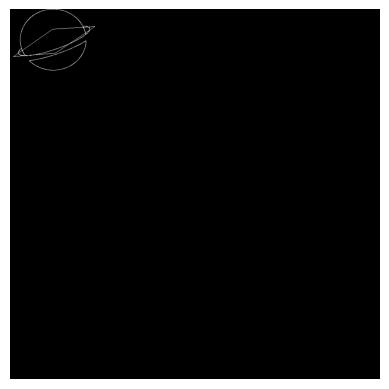

In [31]:
# Combine all images into one large image
combined_image = combine_images(images, positions, width=1000, height=1000)
cv2.imwrite("combined_shapes.png", combined_image)

plt.imshow(combined_image, cmap='gray')
plt.axis('off')
plt.show()

## Convert result image to polylines

In [29]:
# Creating polylines for output combined image
columns = ["ShapeType", "CurveID", "X", "Y"]
df_output = pd.DataFrame(output_data, columns=columns)
df_output.to_csv("shapes_coordinates.csv", index=False)